2DOF :  2 angles
Circular obstacles that it cannot bump into
1. Calculate config space for these two robots 
2. Make arms rectangular 
3. You can decide length and width of arms
4. 3 spheres obstacles -> you decide diameter and location
5. Calculate configuration space by randomly sampling and see if it collides
    1. Sample every combination 
    2. Get an image  - > (workspace, config_space)
6.  Train from work space to estimate config space
    1. See if shape 


In [245]:
import math
from shapely.geometry import Polygon,Point,LineString,MultiPoint
from shapely import affinity
import matplotlib.pyplot as plt

In [246]:
def round_point(point):
    return Point(round(point.x,4),round(point.y,4))

def round_polygon(ls):
    linestring = []
    for point in ls.exterior.coords:
        linestring.append(Point(round(point[0],4),round(point[1],4)))
    return MultiPoint(linestring).convex_hull

def round_line_string(ls):
    linestring = []
    for point in ls.boundary.geoms:
        linestring.append(Point(round(point.x,4),round(point.y,4)))
    return LineString(linestring)

def get_upper_joint(rot,possible_joints):
    joint = None
    if arm_1_rot == 0:
        joint = sorted(poossible_joints, key= lambda x : x[1])[0]
    elif 0 < arm_1_rot < 180:
        joint = sorted(poossible_joints,key=lambda x: -x[0])[0]
    elif arm_1_rot == 180:
        joint = sorted(poossible_joints,key=lambda x: -x[1])[0]
    elif 180 < arm_1_rot < 360:
        joint = sorted(poossible_joints,key=lambda x: x[0])[0]
    return joint

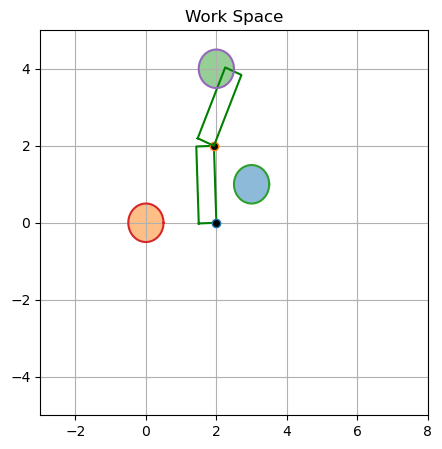

In [250]:
import math
from shapely.geometry import LineString,MultiPoint,Point,mapping
import matplotlib.pyplot as plt
from shapely import affinity

# two functions for plotting
def plot_coords(coords):
    pts = list(coords)
    x, y = zip(*pts)
    plt.plot(x,y)

def plot_polys(polys):
    for poly in polys:
        plot_coords(poly.exterior.coords)
        plt.fill_between(*poly.exterior.xy, alpha=.5)

robot_arm1_og = MultiPoint(list([Point(2,0),Point(4,0),Point(2,.5),Point(4,.5)])).convex_hull
total_arm_og = MultiPoint(list([Point(2,0),Point(6,0),Point(2,.5),Point(6,.5)])).convex_hull
arm_1_rot = 92
arm1_joint = (2,0)
robot_arm1 = round_polygon(affinity.rotate(robot_arm1_og,arm_1_rot,arm1_joint))
total_a = round_polygon(affinity.rotate(total_arm_og,arm_1_rot,arm1_joint))

total_a_coords = set([*total_a.exterior.coords])
arm_1_coords = set([*robot_arm1.exterior.coords])
upper_arm_coords = total_a_coords.difference(arm_1_coords).union(arm_1_coords.difference(total_a_coords))
upper_arm = MultiPoint(list(upper_arm_coords)).convex_hull

poossible_joints = list(arm_1_coords.intersection(upper_arm_coords))

upper_arm_joint = get_upper_joint(arm_1_rot,poossible_joints)

upper_arm_rotate = affinity.rotate(upper_arm,-25,upper_arm_joint)

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(*robot_arm1.exterior.xy,color='green')
ax.plot(arm1_joint[0],arm1_joint[1],marker="o",markerfacecolor="black")
ax.plot(upper_arm_joint[0],upper_arm_joint[1],marker="o",markerfacecolor="black")
ax.plot(*upper_arm_rotate.exterior.xy,color='green')

obst_1 = Point(3,1).buffer(.5)
obst_2 = Point(0,0).buffer(.5)
obst_3 = Point(2,4).buffer(.5)

obstacles = [obst_1,obst_2,obst_3]

ax.set_title("Work Space")
ax.set_xlim([-3,8])
ax.set_ylim([-5,5])
# ax.set_aspect( 1 )
plot_polys(obstacles)
plt.grid()

In [248]:
def calculate_cobs_iter(robot_arm1,total_arm,q_1,q_2,obst,ref_pt):
    c_obs_pts = []
    for i in q_1:
        arm_1_rotated = round_polygon(affinity.rotate(robot_arm1_og,i,ref_pt))
        total_arm_rotated = round_polygon(affinity.rotate(total_arm_og,i,ref_pt))

        total_arm_coords = set([*total_arm_rotated.exterior.coords])
        arm_1_coords = set([*arm_1_rotated.exterior.coords])
        upper_arm_coords = total_a_coords.difference(arm_1_coords).union(arm_1_coords.difference(total_arm_coords))
        upper_arm = MultiPoint(list(upper_arm_coords)).convex_hull

        poossible_joints = list(arm_1_coords.intersection(upper_arm_coords))
        upper_arm_joint = get_upper_joint(arm_1_rot,poossible_joints)

        for j in q_2:
            arm_2_rotated = round_polygon(affinity.rotate(upper_arm,j,upper_arm_joint))
            # if type(arm_2_rotated.intersection(arm_1_rotated)) != Point:
            #     c_obs_pts.append((i,abs(j)))
            #     break
            for o in obst:
                if arm_2_rotated.intersects(o) or arm_1_rotated.intersects(o):
                    c_obs_pts.append((i,abs(j)))
                    break
    return c_obs_pts

# def calculate_cobs(robot_arm1,total_arm,q_1,q_2,obst):
#     rf_pt = robot_arm1.boundary.geoms[0]
#     c_obs_pts = []
#     for i in range(q_1[0],q_1[1]+1):
#         arm_1_rotated = round_line_string(affinity.rotate(arm_1,i,rf_pt))
#         total_arm_rotated = round_line_string(affinity.rotate(total_arm,i,rf_pt))
#         arm_2 = round_line_string(LineString([arm_1_rotated.boundary.geoms[1],total_arm_rotated.boundary.geoms[1]]))
#         arm_2_rf_pt = arm_2.boundary.geoms[0]
#         for j in range(q_2[0],q_2[1]-1,-1):
#             arm_2_rotated = round_line_string(affinity.rotate(arm_2,j,arm_2_rf_pt))
#             if type(arm_2_rotated.intersection(arm_1_rotated)) != Point:
#                 c_obs_pts.append((i,abs(j)))
#                 break
#             for o in obst:
#                 if arm_2_rotated.intersects(o) or arm_1_rotated.intersects(o):
#                     c_obs_pts.append((i,abs(j)))
#                     break
#     return c_obs_pts


In [252]:
c_obs_pts = calculate_cobs_iter(robot_arm1_og,total_arm_og,[45,90,92],[-25,0],obstacles,(2,0))
print(c_obs_pts)

[(45, 25), (45, 0), (90, 25), (90, 0), (92, 25), (92, 0)]


In [277]:
import math
from shapely.geometry import LineString,MultiPoint,Point
import matplotlib.pyplot as plt
from shapely import affinity

# two functions for plotting
def plot_coords(ax,coords):
    pts = list(coords)
    x, y = zip(*pts)
    ax.plot(x,y,color='red')

def plot_polys(ax,polys):
    for poly in polys:
        plot_coords(ax,poly.exterior.coords)
        ax.fill_between(*poly.exterior.xy, alpha=.5)

def plot_work_space_with_detected_collision_pts(robot_arm1_og,total_arm_og,obstacles,detected_collision_pts,ref_pt):
    fig,axs = plt.subplots(3,2,figsize=(10,15))
    fig.suptitle("Work space with detected collisions", fontsize=14)
    count = 0
    for i in range(3):
        for j in range(2):
            arm_1_rot,arm_2_rot = c_obs_pts[count]
            count += 1
            robot_arm1 = round_polygon(affinity.rotate(robot_arm1_og,arm_1_rot,ref_pt))
            total_a = round_polygon(affinity.rotate(total_arm_og,arm_1_rot,ref_pt))

            total_a_coords = set([*total_a.exterior.coords])
            arm_1_coords = set([*robot_arm1.exterior.coords])
            upper_arm_coords = total_a_coords.difference(arm_1_coords).union(arm_1_coords.difference(total_a_coords))
            upper_arm = MultiPoint(list(upper_arm_coords)).convex_hull

            poossible_joints = list(arm_1_coords.intersection(upper_arm_coords))

            upper_arm_joint = get_upper_joint(arm_1_rot,poossible_joints)

            upper_arm_rotate = affinity.rotate(upper_arm,arm_2_rot,upper_arm_joint)

            # axs[i,j].plot(*robot_arm1.exterior.xy,color='green')
            # ax[i,j].plot(arm1_joint[0],arm1_joint[1],marker="o",markerfacecolor="black")
            # ax[i,j].plot(upper_arm_joint[0],upper_arm_joint[1],marker="o",markerfacecolor="black")
            ax[i,j].plot(*upper_arm_rotate.exterior.xy,color='green')
            axs[i,j].set_xlim([-2,10])
            axs[i,j].set_ylim([-5,10])
            axs[i,j].grid()
            # arm_1_rot,arm_2_rot = detected_collision_pts[count]
            # count += 1
            # robot_arm1 = round_polygon(affinity.rotate(robot_arm1_og,arm_1_rot,ref_pt))
            # total_arm = round_polygon(affinity.rotate(total_arm_og,arm_1_rot,ref_pt))
            #
            # total_a_coords = set([*total_arm.exterior.coords])
            # arm_1_coords = set([*robot_arm1.exterior.coords])
            # upper_arm_coords = total_a_coords.difference(arm_1_coords).union(arm_1_coords.difference(total_a_coords))
            # upper_arm = MultiPoint(list(upper_arm_coords)).convex_hull
            #
            # poossible_joints = list(arm_1_coords.intersection(upper_arm_coords))
            #
            # upper_arm_joint = get_upper_joint(arm_1_rot,poossible_joints)
            #
            # upper_arm_rotate = affinity.rotate(upper_arm,-25,upper_arm_joint)
            #
            # axs[i,j].plot(*robot_arm1.exterior.xy,color='green')
            # axs[i,j].plot(*upper_arm_rotate.exterior.xy,color='green')
            # axs[i,j].plot(ref_pt[0],ref_pt[1],marker="o",markerfacecolor="black")
            # axs[i,j].plot(upper_arm_joint[0],upper_arm_rotate[1],marker="o",markerfacecolor="black")
            # axs[i,j].set_title(f"Collision at ({arm_1_rot},{arm_2_rot})")
            # plot_polys(axs[i,j],obstacles)
            #
            # axs[i,j].set_xlim([-2,10])
            # axs[i,j].set_ylim([-5,10])
            # axs[i,j].grid()

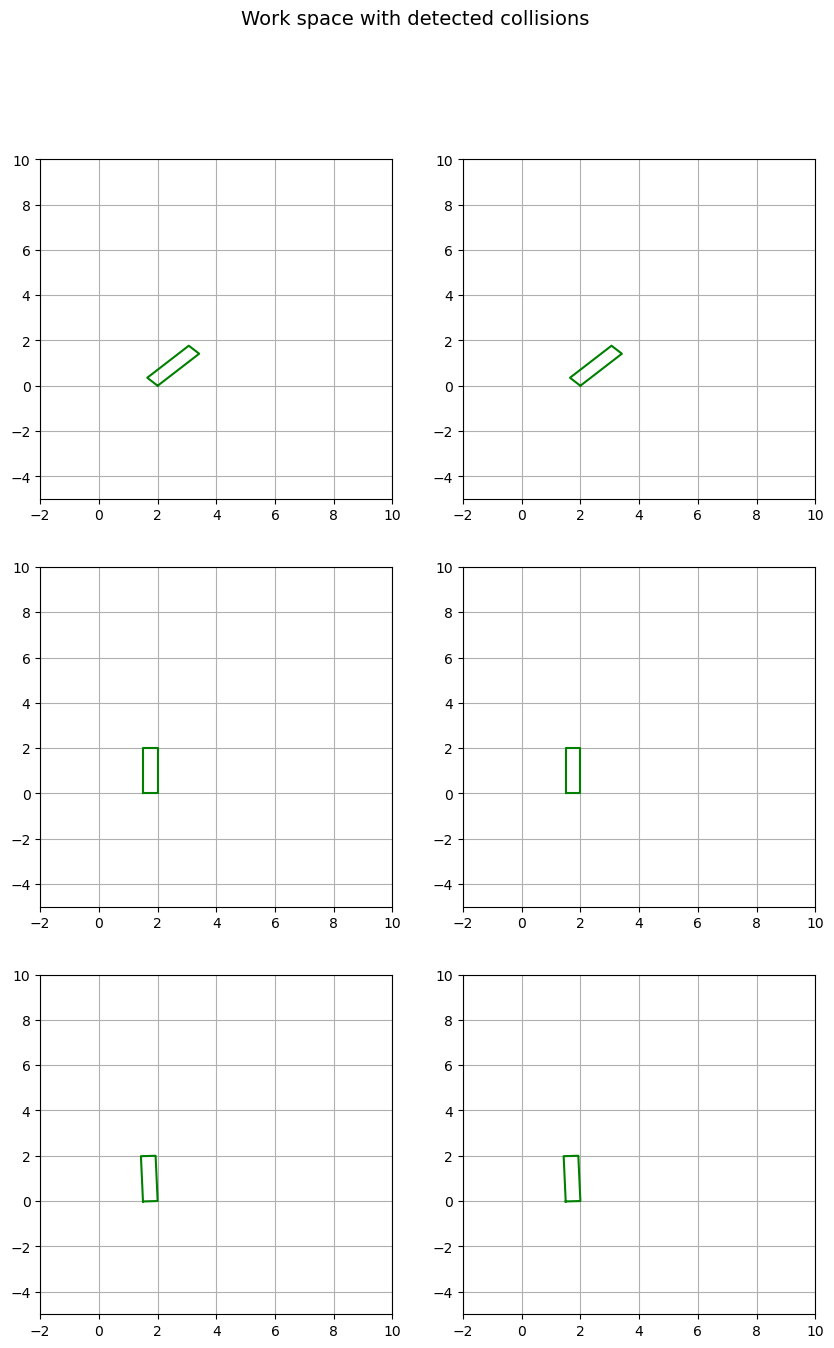

In [271]:
plot_work_space_with_detected_collision_pts(robot_arm1_og,total_arm_og,obstacles,c_obs_pts,(2,0))

In [7]:
c_obs = calculate_cobs(robot_arm1_og,total_arm_og,[0,359],[0,-180],obstacles)

In [8]:
print(len(c_obs))

21371


[]

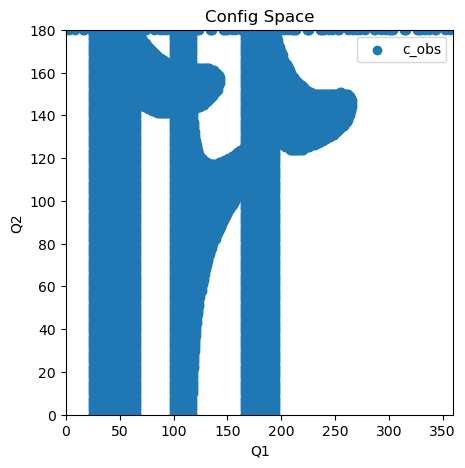

In [9]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(5,5))
ax.set_title("Config Space")
ax.set_xlim([0,360])
ax.set_ylim([0,180])
ax.set_xlabel('Q1')
ax.set_ylabel('Q2')
x_s = list(map(lambda pt: pt[0],c_obs))
y_s = list(map(lambda pt: pt[1],c_obs))
ax.scatter(x_s,y_s,label='c_obs')
ax.legend()
plt.plot()